# Feature Engineering - Expedia Hotel dataset

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
import tensorflow as tf
import warnings
import math
from math import sqrt
import sys
import holidays
import datetime

/Users/yas/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('../data/hotel_data/train.csv', sep=',', nrows=150000)
destinations = pd.read_csv('../data/hotel_data/destinations.csv', sep=',')
df.shape

(150000, 24)

In [3]:
#merge only top 10 most correlated columns with rating column
df = pd.merge(df,destinations[['srch_destination_id','d33', 'd64', 'd52', 'd120', 'd72', 'd136', 'd7', 'd59', 'd50', 'd30']],on='srch_destination_id')

In [4]:
# rename 2 columns
df = df.rename(columns={'hotel_cluster': 'item_id', 'is_booking': 'rating'})

In [5]:
df = df.dropna()

In [6]:
df.shape

(96910, 34)

## Feature Engineering

## date_time

### Extract week and month

In [7]:
# sort values
df = df.sort_values("date_time").reset_index()
df.drop('index',axis=1,inplace=True)

In [8]:
df["date_time"] =  pd.to_datetime(df["date_time"], infer_datetime_format=True)
df["date_time"] = df.date_time.dt.strftime('%Y-%m-%d')
df["date_time_timestamp"] =  pd.to_datetime(df["date_time"], infer_datetime_format=True)

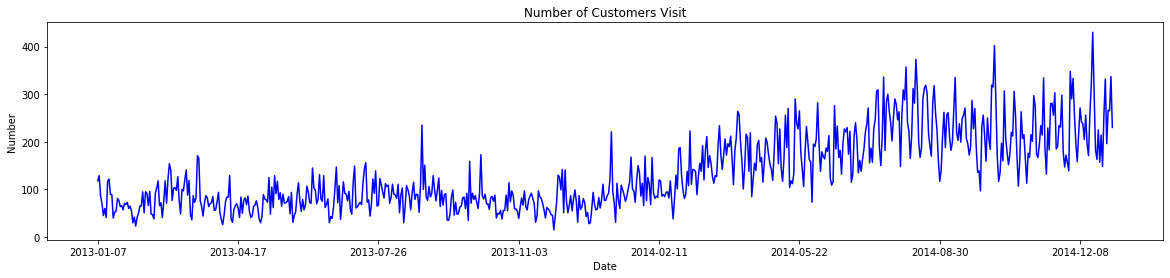

In [9]:
ax= df[['date_time','rating']].groupby('date_time')['rating'].count().plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('Number')
ax.set_title("Number of Customers Visit")
plt.show()

In [10]:
d = datetime.timedelta(days=14)
df['lagged_date_time'] = df["date_time"].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d") + d)

#df["str_lagged_date_time"] = df.lagged_date_time.dt.strftime('%Y-%m-%d')
#df["lagged_date_time"][1].strftime("%B")
#df["date_time_timestamp"].apply(lambda x: x.strftime("%Y-%U-%w"))

In [11]:
df['num_visit']=1

In [12]:
df_test = df.groupby([pd.Grouper(key='lagged_date_time', freq='W-MON')])['num_visit'].count().reset_index().set_index('lagged_date_time').sort_values('lagged_date_time')

In [13]:
df_test=df_test.reset_index()

In [14]:
df_test

,lagged_date_time,num_visit
0,2013-01-21,118
1,2013-01-28,548
2,2013-02-04,528
3,2013-02-11,476
4,2013-02-18,316
...,...,...
100,2014-12-22,1722
101,2014-12-29,1565
102,2015-01-05,1786
103,2015-01-12,1678


In [15]:
def extract_week(feature,week,lag):
    df[feature] =  pd.to_datetime(df[feature], infer_datetime_format=True)
    df[feature] = df.date_time.dt.strftime('%Y-%m-%d')
    if lag == True:
        d = datetime.timedelta(days=14)
        df['lag_date_time'] = df[feature].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d") + d)
        df['week'] = pd.DatetimeIndex(df['lag_date_time']).week
        df['year']=pd.DatetimeIndex(df['lag_date_time']).year
        
        # countinue week numbers for the next year
        df[week] = df['week'].where(df['year'] ==2013 , df['week']+52)

In [16]:
extract_week('date_time','click_week',lag=True)

In [17]:
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,d59,d50,d30,date_time_timestamp,lagged_date_time,num_visit,lag_date_time,week,year,click_week
0,2013-01-07,2,3,66,331,2428,477.1799,191940,0,0,...,-2.185435,-2.185435,-2.185435,2013-01-07,2013-01-21,1,2013-01-21,4,2013,4
1,2013-01-07,2,3,66,174,46432,2738.4972,144246,0,1,...,-2.293998,-2.293998,-2.293998,2013-01-07,2013-01-21,1,2013-01-21,4,2013,4
2,2013-01-07,2,3,66,331,2428,477.1799,191940,0,0,...,-2.185435,-2.185435,-2.185435,2013-01-07,2013-01-21,1,2013-01-21,4,2013,4
3,2013-01-07,2,3,66,174,46432,2387.7275,144246,0,1,...,-2.342028,-2.342028,-2.306268,2013-01-07,2013-01-21,1,2013-01-21,4,2013,4
4,2013-01-07,2,3,66,174,46432,2384.9256,144246,0,1,...,-2.348217,-2.345951,-2.343426,2013-01-07,2013-01-21,1,2013-01-21,4,2013,4


In [18]:
# extract month from date_time
df['click_month'] = pd.DatetimeIndex(df['date_time']).month

## checkin_month , checkout_month

In [19]:
df['checkin_month'] = pd.DatetimeIndex(df['srch_ci']).month
df['checkout_month'] = pd.DatetimeIndex(df['srch_co']).month

df['checkin_year'] = pd.DatetimeIndex(df['srch_ci']).year
df['checkout_year'] = pd.DatetimeIndex(df['srch_co']).year

In [20]:
df.iloc[1]['srch_co']#-df.iloc[1]['srch_ci']

'2013-04-16'

## extract duration

In [21]:
df['duration']=(df["srch_co"].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d")) - 
 df["srch_ci"].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d")))

In [22]:
df["duration"] = df["duration"].apply(lambda x:str(x).split("days")[0].split(" ")[0])

## add holiday

In [23]:
# Define holidays in some countries
ca_holidays = holidays.Canada()
us_holidays = holidays.UnitedStates()

In [24]:
# check if checkin or checkout date is in holiday of different countries

df['north_am_ci'] = df['srch_ci'].apply(lambda x: 1 if x in (us_holidays or ca_holidays)  else 0)
df['north_am_co'] = df['srch_co'].apply(lambda x: 1 if x in (us_holidays or ca_holidays)  else 0)

In [25]:
df= df.drop(['date_time'],axis=1)
df= df.drop(['week'],axis=1)
df= df.drop(['year'],axis=1)
df= df.drop(['srch_ci'],axis=1)
df= df.drop(['srch_co'],axis=1)
df= df.drop(['lag_date_time'],axis=1)
df= df.drop(['date_time_timestamp'],axis=1)
df= df.drop(['lagged_date_time'],axis=1)
df= df.drop(['num_visit'],axis=1)

In [26]:
df.columns

Index(['site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'rating', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'item_id', 'd33',
       'd64', 'd52', 'd120', 'd72', 'd136', 'd7', 'd59', 'd50', 'd30',
       'click_week', 'click_month', 'checkin_month', 'checkout_month',
       'checkin_year', 'checkout_year', 'duration', 'north_am_ci',
       'north_am_co'],
      dtype='object')

## site_name
ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, …)

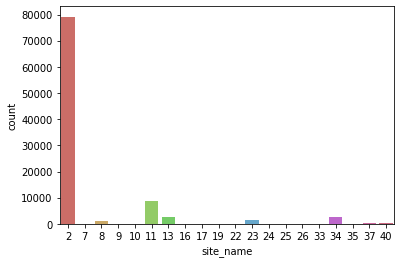

In [27]:
sns.countplot(x=df['site_name'],palette='hls',order=sorted(df['site_name'].unique()))
plt.show()

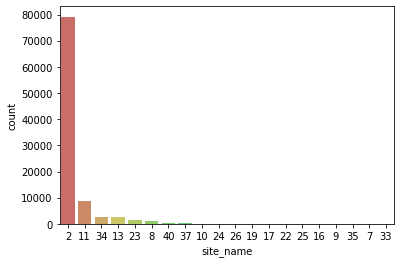

In [28]:
sns.countplot(x=df['site_name'],palette='hls',order=df['site_name'].value_counts().index)
plt.show()

## Check for poisson distribution

In [29]:
from statistics import variance, mean

mean(df['site_name']) ,variance(df['site_name'])


(4.753740584047054, 50.804796448609345)

### orig_destination_distance
Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated

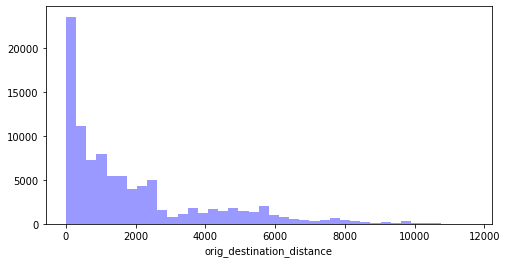

In [30]:
plt.figure(figsize=(8, 4))
sns.distplot(df['orig_destination_distance'],kde=False,bins=40,color='b')

In [31]:
#Note that we add 1 to the raw count to prevent the logarithm from
# exploding into negative infinity in case the count is zero.
df['log_orig_destination_distance'] = np.log10(df['orig_destination_distance'] + 1)

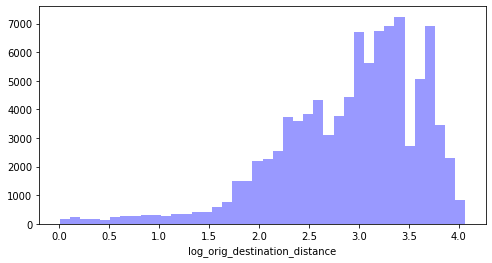

In [32]:
plt.figure(figsize=(8, 4))
sns.distplot(df['log_orig_destination_distance'],kde=False,bins=40,color='b')

In [33]:
df= df.drop(['orig_destination_distance'],axis=1)

## posa_continent
ID of continent associated with site_name

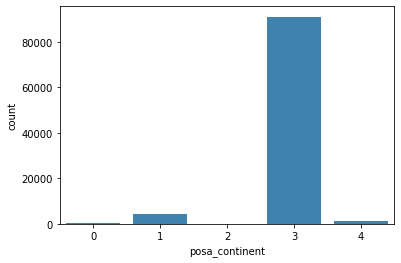

In [34]:
sns.countplot(x=df['posa_continent'],color='#2E86C1')
plt.show()

## user_location_country
The ID of the country the customer is located

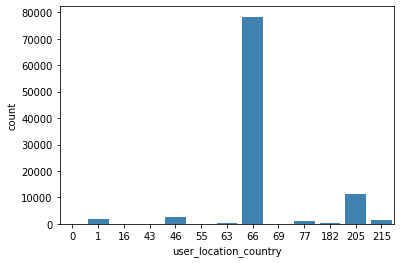

In [35]:
sns.countplot(x=df['user_location_country'],color='#2E86C1')
plt.show()

## user_location_region
The ID of the region the customer is located

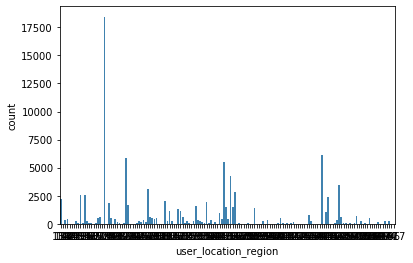

In [36]:
sns.countplot(x=df['user_location_region'],color='#2E86C1')
plt.show()

## Create clusters

In [37]:
df.columns

Index(['site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city', 'user_id', 'is_mobile',
       'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'rating', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'item_id', 'd33', 'd64', 'd52', 'd120', 'd72', 'd136', 'd7', 'd59',
       'd50', 'd30', 'click_week', 'click_month', 'checkin_month',
       'checkout_month', 'checkin_year', 'checkout_year', 'duration',
       'north_am_ci', 'north_am_co', 'log_orig_destination_distance'],
      dtype='object')

In [38]:
df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_adults_cnt,...,click_week,click_month,checkin_month,checkout_month,checkin_year,checkout_year,duration,north_am_ci,north_am_co,log_orig_destination_distance
0,2,3,66,331,2428,191940,0,0,0,6,...,4,1,1,1,2013,2013,3,0,0,2.679591
1,2,3,66,174,46432,144246,0,1,9,2,...,4,1,4,4,2013,2013,4,0,0,3.437671
2,2,3,66,331,2428,191940,0,0,0,6,...,4,1,1,1,2013,2013,3,0,0,2.679591
3,2,3,66,174,46432,144246,0,1,9,2,...,4,1,4,4,2013,2013,5,0,0,3.378167
4,2,3,66,174,46432,144246,0,1,9,2,...,4,1,4,4,2013,2013,5,0,0,3.377657


In [39]:
def create_cluster(feature):
    y = df[feature]
    X = df.drop(feature,axis=1)
    wcss=[]
    for i in range(1,11):
        kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1,11), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('number of clusters')
    plt.ylabel('wcss')
    plt.show()

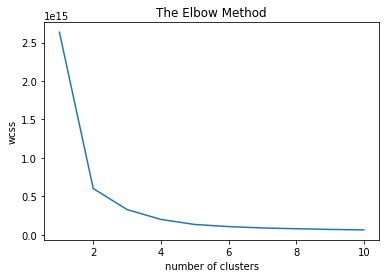

In [40]:
create_cluster('user_location_region')

In [41]:
X = df.drop("user_location_region",axis=1)
kmeansmodel = KMeans(n_clusters= 2, init='k-means++', random_state=0)
y_kmeans= kmeansmodel.fit_predict(X)
df['kmeans_user_location_region']=y_kmeans
df= df.drop(['user_location_region'],axis=1)

## user_location_city
The ID of the country the customer is located

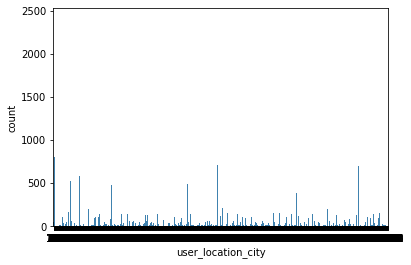

In [42]:
sns.countplot(x=df['user_location_city'],color='#2E86C1')
plt.show()

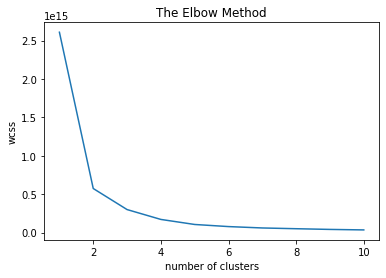

In [43]:
create_cluster('user_location_city')

In [44]:
X = df.drop("user_location_city",axis=1)
kmeansmodel = KMeans(n_clusters= 2, init='k-means++', random_state=0)
y_kmeans= kmeansmodel.fit_predict(X)
df['kmeans_user_location_city']=y_kmeans
df= df.drop(['user_location_city'],axis=1)

In [45]:
df.head()

,site_name,posa_continent,user_location_country,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,...,checkin_month,checkout_month,checkin_year,checkout_year,duration,north_am_ci,north_am_co,log_orig_destination_distance,kmeans_user_location_region,kmeans_user_location_city
0,2,3,66,191940,0,0,0,6,0,3,...,1,1,2013,2013,3,0,0,2.679591,0,1
1,2,3,66,144246,0,1,9,2,0,1,...,4,4,2013,2013,4,0,0,3.437671,0,1
2,2,3,66,191940,0,0,0,6,0,3,...,1,1,2013,2013,3,0,0,2.679591,0,1
3,2,3,66,144246,0,1,9,2,0,1,...,4,4,2013,2013,5,0,0,3.378167,0,1
4,2,3,66,144246,0,1,9,2,0,1,...,4,4,2013,2013,5,0,0,3.377657,0,1


## channel:
ID of a marketing channel

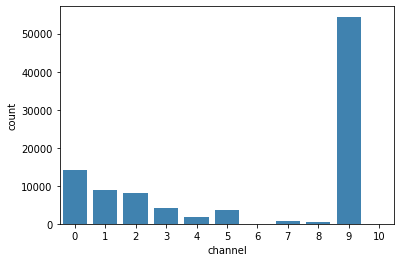

In [46]:
sns.countplot(x=df['channel'],color='#2E86C1')
plt.show()

## srch_adults_cnt , srch_children_cnt
The number of adults specified in the hotel room

The number of (extra occupancy) children specified in the hotel room',


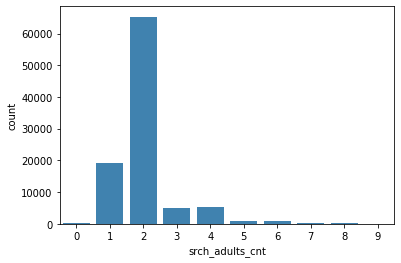

In [47]:
sns.countplot(x=df['srch_adults_cnt'],color='#2E86C1')
plt.show()

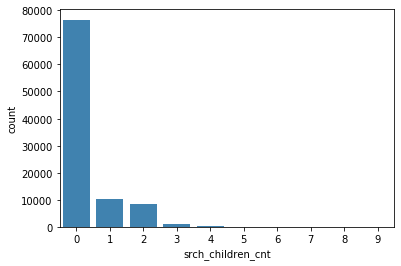

In [48]:
sns.countplot(x=df['srch_children_cnt'],color='#2E86C1')
plt.show()

In [49]:
condlist = [(df['srch_adults_cnt']==0) & (df['srch_children_cnt']==0),
            (df['srch_adults_cnt']==2) & (df['srch_children_cnt']==0),
            (df['srch_adults_cnt']==2) & (df['srch_children_cnt']==1),
            (df['srch_adults_cnt']==2) & (df['srch_children_cnt']==2),
           (df['srch_adults_cnt']==1) & (df['srch_children_cnt']==0),
            (df['srch_adults_cnt']>1) & (df['srch_children_cnt']>0),
           (df['srch_adults_cnt']==1) & (df['srch_children_cnt'] > 0),
           (df['srch_adults_cnt']>2) & (df['srch_children_cnt'] == 0),
           (df['srch_adults_cnt']==0) & (df['srch_children_cnt'] > 0)]

choicelist = ['empty_room',
                'couple_with_no_children',
                'couple_with_one_child',
                'couple_with_two_children',
                'single',
                'big_family',
                'single_parent',
                'friends',
                'unsupervised_children']

df['family_status'] = np.select(condlist,choicelist)

In [50]:
#Convert the family_status into dummy variables
dummies = pd.get_dummies(df['family_status'],drop_first=True)
df= pd.concat( [df.drop('family_status',axis=1),dummies],axis=1)

In [51]:
df=df.drop("unsupervised_children",axis=1)

## srch_rm_cnt
The number of hotel rooms specified in the search

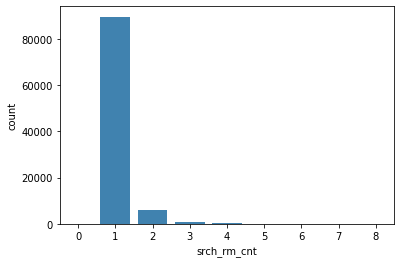

In [52]:
sns.countplot(x=df['srch_rm_cnt'],color='#2E86C1')
plt.show()

## srch_destination_id
ID of the destination where the hotel search was performed

In [53]:
len(df["cnt"].unique())

30

## srch_destination_type_id
Type of destination

## cnt
Numer of similar events in the context of the same user session

In [54]:
from statistics import variance, mean

mean(df['cnt']) ,variance(df['cnt'])

(1.46675265710453, 1.386252846084376)

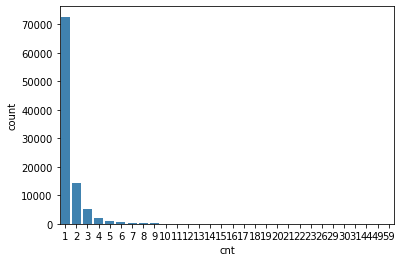

In [55]:
sns.countplot(x=df['cnt'],color='#2E86C1')
plt.show()

## z-score normalizing

In [56]:
df['cnt'] = (df['cnt'] - df['cnt'].mean())/df['cnt'].std()

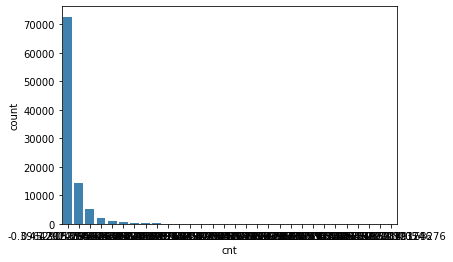

In [57]:
sns.countplot(x=df['cnt'],color='#2E86C1')
plt.show()

## check for poisson distribution

In [58]:
mean(df['cnt']) ,variance(df['cnt'])

(1.8768737810787266e-17, 1.0000000000000002)

'hotel_continent':'Hotel continent',
'hotel_country':'Hotel country',
'hotel_market':'Hotel market',